<a href="https://colab.research.google.com/github/gopalkalpande/20-Newsgroups/blob/master/vector_creation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.externals import joblib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/data/20 news group problem/"


20news-bydate-test		       test.csv
20news-bydate-train		       test_tf_idf.joblib
flair				       train.csv
GoogleNews-vectors-negative300.bin     train_tf_idf.joblib
GoogleNews-vectors-negative300.bin.gz  xgb_clf.pickle.dat


In [0]:
df = pd.read_csv('/content/drive/My Drive/data/20 news group problem/train.csv')
df1 = pd.read_csv('/content/drive/My Drive/data/20 news group problem/test.csv')


rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
sci.space                   593
comp.windows.x              593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: NewsGroup, dtype: int64


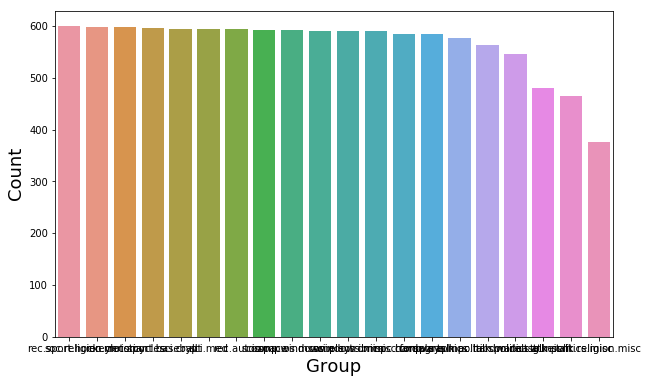

In [5]:
data_per_group = df.NewsGroup.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(data_per_group.index, data_per_group.values)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Group', fontsize=18);

print(data_per_group)

In [0]:
import re

def decontracted(phrase):
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [8]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_news = []
# tqdm is for printing the status bar
for news in tqdm(df.News):
    news = re.sub('<.*?>', '', news)
    news = re.sub(r"http\S+", "", news)
    news = BeautifulSoup(news, 'lxml').get_text()
    news = decontracted(news)
    news = re.sub("\S*\d\S*", "", news).strip()
    news = re.sub('[^A-Za-z]+', ' ', news)
    # https://gist.github.com/sebleier/554280
    news = ' '.join(e.lower() for e in news.split() if e.lower() not in stopwords)
    preprocessed_news.append(news.strip())

    

100%|██████████| 11314/11314 [00:07<00:00, 1575.71it/s]


In [9]:
preprocessed_news_test = []
# tqdm is for printing the status bar
for news in tqdm(df1.News):
    news = re.sub('<.*?>', '', news)
    news = re.sub(r"http\S+", "", news)
    news = BeautifulSoup(news, 'lxml').get_text()
    news = decontracted(news)
    news = re.sub("\S*\d\S*", "", news).strip()
    news = re.sub('[^A-Za-z]+', ' ', news)
    # https://gist.github.com/sebleier/554280
    news = ' '.join(e.lower() for e in news.split() if e.lower() not in stopwords)
    preprocessed_news_test.append(news.strip())


100%|██████████| 7532/7532 [00:04<00:00, 1654.89it/s]


In [10]:
# download flair library #
import torch
!pip install flair
import flair
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
from flair.embeddings import CharacterEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.embeddings import FlairEmbeddings
from flair.embeddings import BertEmbeddings
from flair.embeddings import ELMoEmbeddings
from flair.embeddings import FlairEmbeddings


     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 798kB 10.3MB/s 
     |████████████████████████████████| 133kB 46.2MB/s 
     |████████████████████████████████| 1.0MB 44.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/70/55/6b/c12cf58209b8346f653a04f37dd8f607ab0e85a26238a23420
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Stored in directory: /root/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
Successfully built flair segtok mpld3 sqlitedict


In [11]:
### Initialising embeddings (un-comment to use others) ###
#glove_embedding = WordEmbeddings('glove')
#character_embeddings = CharacterEmbeddings()
flair_forward  = FlairEmbeddings('news-forward-fast')
flair_backward = FlairEmbeddings('news-backward-fast')
#bert_embedding = BertEmbedding()
#elmo_embedding = ElmoEmbedding()

stacked_embeddings = StackedEmbeddings( embeddings = [ flair_forward, flair_backward  ])

stacked = StackedEmbeddings( embeddings = [ flair_forward, flair_backward])

2019-05-03 06:55:31,431 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpjt2u5a8m


100%|██████████| 19689779/19689779 [00:01<00:00, 12458846.06B/s]

2019-05-03 06:55:33,581 copying /tmp/tmpjt2u5a8m to cache at /root/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt


2019-05-03 06:55:33,606 removing temp file /tmp/tmpjt2u5a8m
2019-05-03 06:55:40,825 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpiaiaavys


100%|██████████| 19689779/19689779 [00:01<00:00, 13761781.52B/s]

2019-05-03 06:55:42,766 copying /tmp/tmpiaiaavys to cache at /root/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt
2019-05-03 06:55:42,789 removing temp file /tmp/tmpiaiaavys


In [14]:
#text = preprocessed_news
txt = preprocessed_news
print(txt[:1])

['mathew subject alt atheism faq atheist resources summary books addresses music anything related atheism keywords faq atheism books music fiction addresses contacts expires thu apr gmt distribution world organization mantis consultants cambridge uk supersedes lines archive name atheism resources alt atheism archive name resources last modified december version atheist resources addresses atheist organizations usa freedom religion foundation darwin fish bumper stickers assorted atheist paraphernalia available freedom religion foundation us write ffrf p box madison wi telephone evolution designs evolution designs sell darwin fish fish symbol like ones christians stick cars feet word darwin written inside deluxe moulded plastic fish postpaid us write evolution designs laurel canyon north hollywood ca people san francisco bay area get darwin fish lynn gold try mailing net people go lynn directly price per fish american atheist press aap publish various atheist books critiques bible lists 

In [15]:
len(txt)

11314

In [17]:
from tqdm import tqdm ## tracks progress of loop ##

z = 2048
# creating a tensor for storing sentence embeddings #
s = torch.zeros(0,z)

# iterating Sentence (tqdm tracks progress) #
for tweet in tqdm(txt):   
  # empty tensor for words #
  w = torch.zeros(0,z)   
  sentence = Sentence(tweet)
  stacked_embeddings.embed(sentence)
  # for every word #
  for token in sentence:
    # storing word Embeddings of each word in a sentence #
    w = torch.cat((w,token.embedding.view(-1,z)),0)
  # storing sentence Embeddings (mean of embeddings of all words)   #
  s = torch.cat((s, w.mean(dim = 0).view(-1, z)),0)

100%|██████████| 11314/11314 [1:14:45<00:00,  4.89it/s]


In [19]:
joblib.dump(s, "/content/drive/My Drive/data/20 news group problem/FlairWordEmbededVector1.joblib")

['/content/drive/My Drive/data/20 news group problem/FlairWordEmbededVector1.joblib']

In [20]:
txt = preprocessed_news_test
print(txt[:1])

['nanci ann miller subject amusing atheists agnostics organization sponsored account school computer science carnegie mellon pittsburgh pa lines nntp posting host reply timmbake mcl ucsb edu bake timmons writes lies hypocrisy dude atheism takes much faith theism admit people might think takes faith atheist faith take kind faith say great invisible pink unicorn not exist take kind faith say santa claus not exist may people suppose certainly not big leap faith say things god exist suppose depends notion definition faith besides not believing god means one not deal extra baggage comes leaves person feeling wonderfully free especially beaten head years agree religion belief often important psychological healer many people reason think important however trying force psychological fantasy not mean bad way really someone else not interested extremely rude still believed santa claus said belief santa wonderful things life making better person allowing live without guilt etc tried get believe s

In [21]:
from tqdm import tqdm ## tracks progress of loop ##

z = 2048
# creating a tensor for storing sentence embeddings #
s = torch.zeros(0,z)

# iterating Sentence (tqdm tracks progress) #
for tweet in tqdm(txt):   
  # empty tensor for words #
  w = torch.zeros(0,z)   
  sentence = Sentence(tweet)
  stacked_embeddings.embed(sentence)
  # for every word #
  for token in sentence:
    # storing word Embeddings of each word in a sentence #
    w = torch.cat((w,token.embedding.view(-1,z)),0)
  # storing sentence Embeddings (mean of embeddings of all words)   #
  s = torch.cat((s, w.mean(dim = 0).view(-1, z)),0)

100%|██████████| 7532/7532 [40:01<00:00,  3.18it/s]


In [22]:
joblib.dump(s, "/content/drive/My Drive/data/20 news group problem/FlairWordEmbededVector2.joblib")

['/content/drive/My Drive/data/20 news group problem/FlairWordEmbededVector2.joblib']

In [0]:
y_train = df.NewsGroup
y_test = df1.NewsGroup

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


In [0]:
x_train = joblib.load("/content/drive/My Drive/data/20 news group problem/FlairWordEmbededVector1.joblib")
x_test = joblib.load("/content/drive/My Drive/data/20 news group problem/FlairWordEmbededVector2.joblib")

In [0]:
from xgboost import XGBClassifier
classifier = XGBClassifier( n_jobs=-1, n_estimators=200)
classifier.fit(x_train, y_train)

import pickle
pickle.dump(classifier, open("/content/drive/My Drive/data/20 news group problem/xgb_clf_eith_flair.pickle.dat", "wb"))

In [28]:
y_pred = classifier.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.46      0.50       319
           1       0.47      0.59      0.52       389
           2       0.57      0.49      0.53       394
           3       0.45      0.50      0.48       392
           4       0.57      0.56      0.57       385
           5       0.67      0.68      0.68       395
           6       0.69      0.71      0.70       390
           7       0.69      0.54      0.60       396
           8       0.58      0.72      0.64       398
           9       0.73      0.72      0.73       397
          10       0.83      0.75      0.79       399
          11       0.73      0.59      0.65       396
          12       0.43      0.44      0.43       393
          13       0.69      0.69      0.69       396
          14       0.66      0.68      0.67       394
          15       0.63      0.77      0.70       398
          16       0.59      0.66      0.63       364
          17       0.84    

In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

In [0]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
